In [ ]:
# variable for whether running on colab or not
running_on_colab = False

In [ ]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [4]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7


In [5]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "Florida_1_2000.tif")
# training_images.append(image_base_path + "Florida_3_2000.tif")
# training_images.append(image_base_path + "Florida_4_2000.tif")
training_images.append(image_base_path + "Florida_5_2000.tif")
training_images.append(image_base_path + "Florida_6_2000.tif")
training_images.append(image_base_path + "Florida_7_2000.tif")

# training_images.append(image_base_path + "Brazil_2_2000.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)

Using training data of length:  3301010
Class 0: 2419556 Class 1: 881454
Class 0:  73.3% Class 1:  26.7%


In [6]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)


(1980606, 1, 7)
(1320404, 1, 7)


In [7]:
# normalize bands
xTrain = diu.normalizeUInt16Band(xTrain)
xTest = diu.normalizeUInt16Band(xTest)

In [8]:
# Define the parameters of the model
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(1, nBands)),
  keras.layers.Dense(14, activation='relu'),
  keras.layers.Dense(14, activation='relu'),
  keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 14)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 30        
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=10)

Epoch 1/10
43326/43326 [==============================] - 79s 2ms/step - loss: 0.2370 - accuracy: 0.8987 - val_loss: 0.2082 - val_accuracy: 0.9150 0s - loss: 0.2371 - accuracy: 
Epoch 2/10
43326/43326 [==============================] - 74s 2ms/step - loss: 0.2009 - accuracy: 0.9164 - val_loss: 0.1986 - val_accuracy: 0.9148
Epoch 3/10
43326/43326 [==============================] - 74s 2ms/step - loss: 0.1970 - accuracy: 0.9173 - val_loss: 0.1653 - val_accuracy: 0.9344
Epoch 4/10
43326/43326 [==============================] - 80s 2ms/step - loss: 0.1634 - accuracy: 0.9366 - val_loss: 0.1587 - val_accuracy: 0.9388
Epoch 5/10
43326/43326 [==============================] - 72s 2ms/step - loss: 0.1594 - accuracy: 0.9383 - val_loss: 0.1555 - val_accuracy: 0.9386
Epoch 6/10
43326/43326 [==============================] - 72s 2ms/step - loss: 0.1554 - accuracy: 0.9392 - val_loss: 0.1533 - val_accuracy: 0.9402
Epoch 7/10
43326/43326 [==============================] - 70s 2ms/step - loss: 0.1550 -

In [14]:
# save model
# model.save('../DataAndModels/basicNN_Model_TrainingImages_1_5_6_7_Epochs10.h5')

{'loss': [0.20903562009334564, 0.19962915778160095, 0.19119024276733398, 0.16200770437717438, 0.1578693985939026, 0.1554848700761795, 0.1547766774892807, 0.1537540853023529, 0.15310126543045044, 0.15271052718162537], 'accuracy': [0.9123168587684631, 0.9166813492774963, 0.9206454753875732, 0.9374368786811829, 0.9386811256408691, 0.9391751885414124, 0.9395033717155457, 0.9398120641708374, 0.939964234828949, 0.9400926232337952], 'val_loss': [0.20819993317127228, 0.19859130680561066, 0.16528889536857605, 0.15871824324131012, 0.15552674233913422, 0.15333779156208038, 0.1526891142129898, 0.15365932881832123, 0.1550828218460083, 0.1514691710472107], 'val_accuracy': [0.9150327444076538, 0.9148105978965759, 0.9344207644462585, 0.9388234615325928, 0.9385979175567627, 0.9401934146881104, 0.9396212100982666, 0.9397003054618835, 0.938251256942749, 0.9407555460929871]}


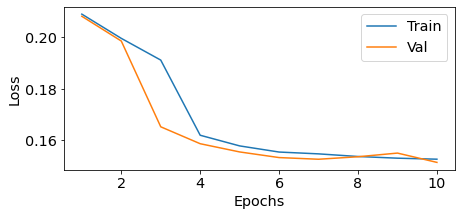

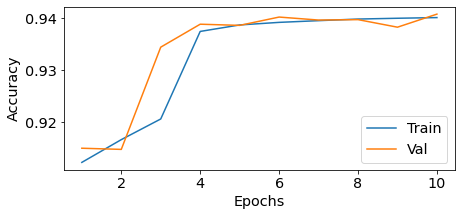

In [26]:
# for plotting of model fit convergence
if 0:
    print(history.history)

    import matplotlib.pyplot as plt

    # could make some plots of the metrics/convergance - f1 would be a better plotting score but just go with accuracy since it's easier
    fig, ax = plt.subplots(figsize=(7,3))

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(loss)+1)

    ax.plot(epochs, loss, label='Train')
    ax.plot(epochs, val_loss, label='Val')

    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    ax.legend();

    plt.savefig("SavedPlots/BasicNN_Convergence_Loss.png", bbox_inches='tight')


    fig, ax = plt.subplots(figsize=(7,3))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    ax.plot(epochs, acc, label='Train')
    ax.plot(epochs, val_acc, label='Val')

    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    ax.legend();

    plt.savefig("SavedPlots/BasicNN_Convergence_Accuracy.png", bbox_inches='tight')

Confusion matrix:
 [[926951  40871]
 [ 37181 315401]]

P-Score: 0.885, R-Score: 0.895
Accuracy: 0.941
f1: 0.890
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    967822
         1.0       0.89      0.89      0.89    352582

    accuracy                           0.94   1320404
   macro avg       0.92      0.93      0.92   1320404
weighted avg       0.94      0.94      0.94   1320404



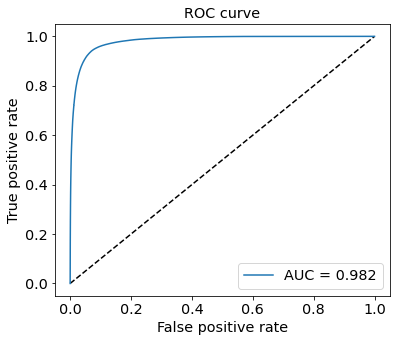

0.9816174601201841

In [11]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob)



Predicting for image: ../SatelliteImages/Florida_3_2000.tif

Image 2000 NDVI band:


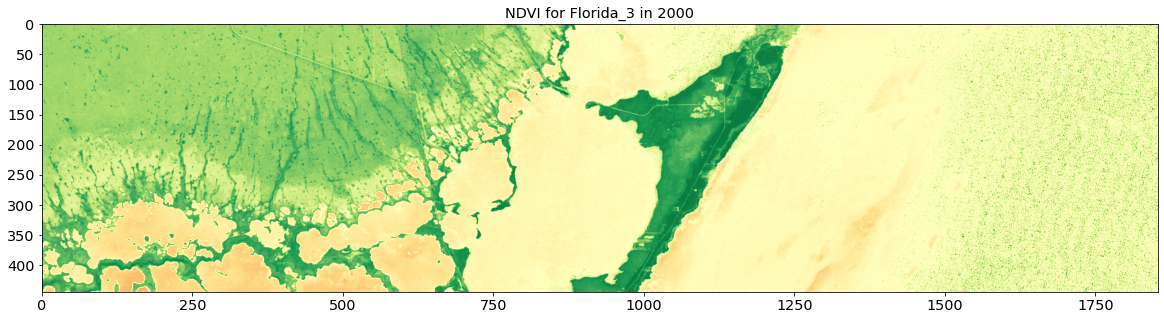


Label mangroves from 2000 data:


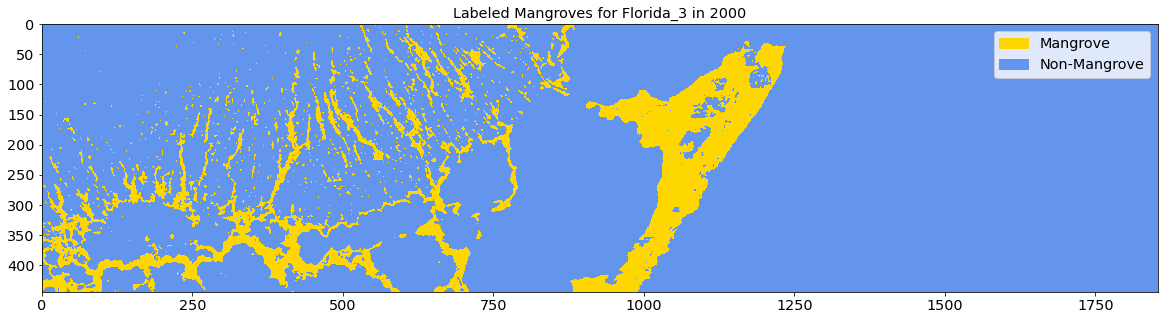


Predicted mangroves:


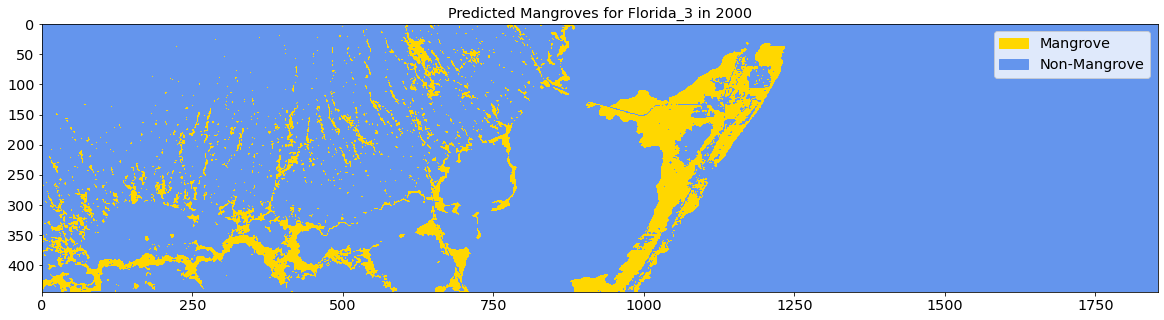


Difference between predicted and labeled mangroves from the year 2000:


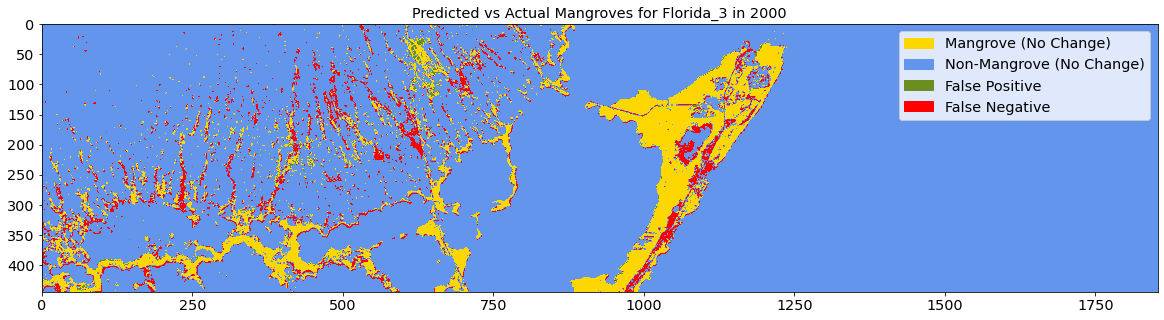

Confusion matrix:
 [[721751   6090]
 [ 28586  68603]]

P-Score: 0.918, R-Score: 0.706
Accuracy: 0.958
f1: 0.798
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    727841
           1       0.92      0.71      0.80     97189

    accuracy                           0.96    825030
   macro avg       0.94      0.85      0.89    825030
weighted avg       0.96      0.96      0.96    825030



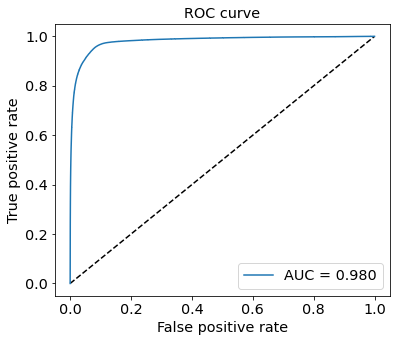

In [12]:
## apply model to new images
diu.predictOnImage(model, image_base_path + "Florida_3_2000.tif")
# diu.predictOnImage(model, image_base_path + "Florida_4_2000.tif")

# diu.predictOnImage(model, image_base_path + "Florida_6_2000.tif")
# diu.predictOnImage(model, image_base_path + "Florida_7_2000.tif")


# diu.predictOnImage(model, image_base_path + "Florida_1_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_3_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_4_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_5_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_6_2020.tif")
# diu.predictOnImage(model, image_base_path + "Florida_7_2020.tif")



# diu.predictOnImage(model, image_base_path + "Brazil_1_2000.tif")


In [13]:
print('not now timeout!')

not now timeout!
